In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose,Resize
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([Resize((32,32)),ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

Label: 0


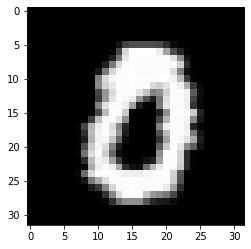

In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

import matplotlib.pyplot as plt
%matplotlib inline

img, label = mnist[69]

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [ ]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 32, 32])
tensor([4, 5, 3, 6, 3, 8, 9, 1, 5, 2, 5, 3, 2, 3, 2, 3, 3, 6, 5, 7, 2, 9, 4, 8,
        6, 2, 0, 7, 5, 8, 6, 8, 5, 1, 6, 2, 9, 9, 1, 8, 1, 6, 2, 1, 0, 5, 7, 5,
        8, 4, 7, 9, 5, 3, 6, 6, 6, 6, 2, 1, 5, 2, 4, 4, 4, 2, 4, 6, 2, 8, 5, 4,
        2, 2, 7, 3, 8, 6, 5, 4, 7, 3, 0, 8, 2, 7, 0, 3, 6, 9, 3, 0, 1, 8, 9, 3,
        4, 6, 4, 9])


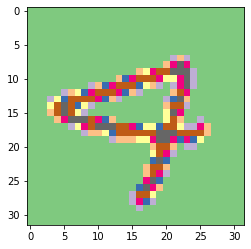

In [ ]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='Accent')
    print(label_batch)
    break

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
image_size = 1024
hidden_size = 256
latent_size = 64

In [ ]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

D.to(device);

In [ ]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [ ]:
y = G(torch.randn(1, latent_size))
gen_imgs = denorm(y.reshape((-1, 32,32)).detach())

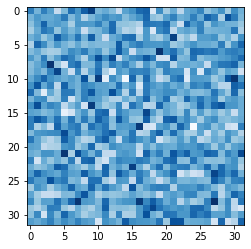

In [ ]:
plt.imshow(gen_imgs[0], cmap='Blues');

In [ ]:
G.to(device);

In [ ]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=3e-4)

In [ ]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score
    

In [ ]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=3e-4)

In [ ]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [ ]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

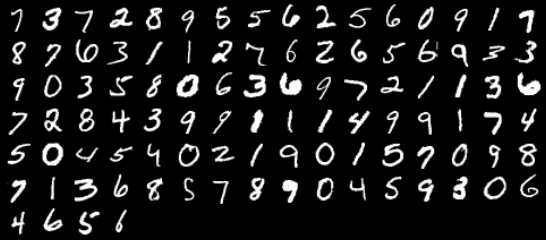

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 32, 32)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=16)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


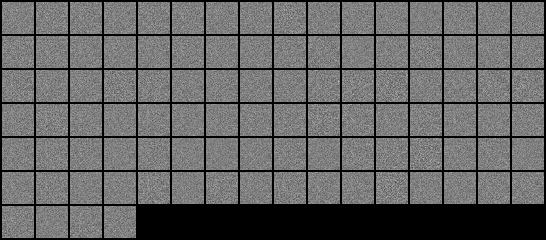

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 32, 32)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=16)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [ ]:
%%time

num_epochs = 50
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/50], Step [200/600], d_loss: 0.1396, g_loss: 6.7242, D(x): 0.95, D(G(z)): 0.05
Epoch [0/50], Step [400/600], d_loss: 0.5037, g_loss: 3.7865, D(x): 0.87, D(G(z)): 0.24
Epoch [0/50], Step [600/600], d_loss: 0.0924, g_loss: 4.0292, D(x): 0.98, D(G(z)): 0.05
Saving fake_images-0001.png
Epoch [1/50], Step [200/600], d_loss: 0.3326, g_loss: 4.7339, D(x): 0.87, D(G(z)): 0.12
Epoch [1/50], Step [400/600], d_loss: 0.2197, g_loss: 5.4960, D(x): 0.93, D(G(z)): 0.08
Epoch [1/50], Step [600/600], d_loss: 0.1933, g_loss: 4.3803, D(x): 0.94, D(G(z)): 0.06
Saving fake_images-0002.png
Epoch [2/50], Step [200/600], d_loss: 0.3177, g_loss: 3.5573, D(x): 0.89, D(G(z)): 0.07
Epoch [2/50], Step [400/600], d_loss: 0.2899, g_loss: 3.8268, D(x): 0.89, D(G(z)): 0.05
Epoch [2/50], Step [600/600], d_loss: 0.1753, g_loss: 5.0130, D(x): 0.94, D(G(z)): 0.06
Saving fake_images-0003.png
Epoch [3/50], Step [200/600], d_loss: 0.3189, g_loss: 4.6972, D(x): 0.89, D(G(z)): 0.08
Epoch [3/50], Step [400/600], d_loss

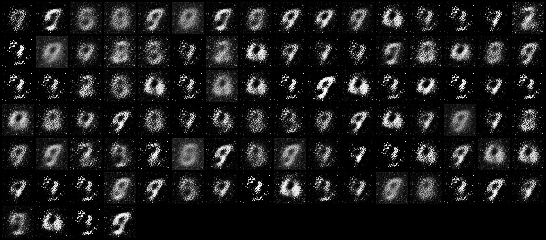

In [ ]:
Image('./samples/fake_images-0010.png')

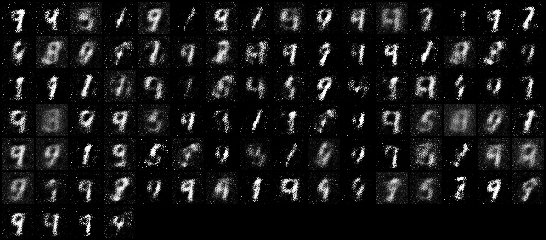

In [ ]:
Image('./samples/fake_images-0020.png')

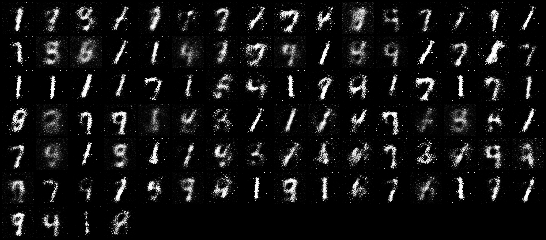

In [ ]:
Image('./samples/fake_images-0030.png')

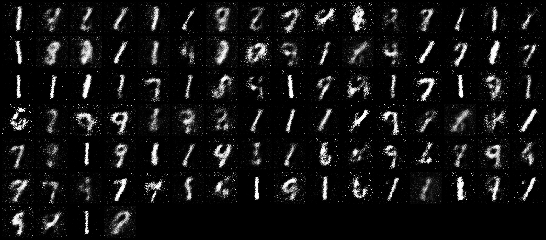

In [ ]:
Image('./samples/fake_images-0040.png')

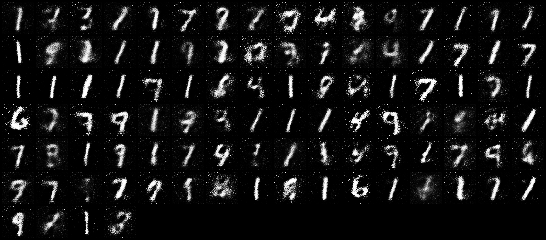

In [ ]:
Image('./samples/fake_images-0050.png')

In [ ]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.avi')

/content/gans_training.avi

In [ ]:
torch.save(G.state_dict(), '/content/drive/MyDrive/gans/G.pth')
torch.save(D.state_dict(), '/content/drive/MyDrive/gans/D.pth')

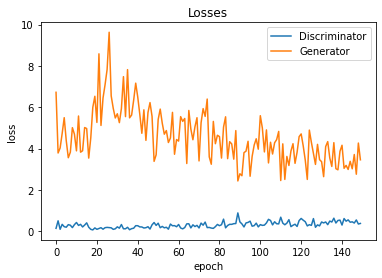

In [ ]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

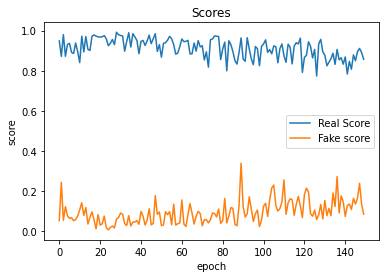

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');